In [1]:
import os
import numpy as np
import h5py
import gc
import datetime
import json

from PIL import Image
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            precision_recall_curve, average_precision_score)

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

First, the list of chosen bird species is defined:

In [2]:
species = [
    'Ciconia_ciconia', 'Columba_livia', 'Streptopelia_decaocto',
    'Emberiza_calandra', 'Carduelis_carduelis', 'Serinus_serinus',
    'Delichon_urbicum', 'Hirundo_rustica', 'Passer_domesticus',
    'Sturnus_unicolor', 'Turdus_merula'
]

And some settings are defined for pre-processing the images.

In [3]:
DATA_DIR = 'new_dataset'                    
MODEL_SAVE_DIR = 'saved_models'
OUTPUT_FILE = 'bird_dataset_pytorch.h5'     

IMG_SIZE = (224, 224)                       # Standard size for CNNs
TEST_SIZE = 0.15                            # Test set proportion
TRAIN_SIZE = 0.70                           # Train set proportion
COMPRESSION = 'gzip'                        # Compression type
COMPRESSION_LEVEL = 7                       # Compression level (1-9)

N_SPLITS = 3                                # Number of splits for cross-validation
BATCH_SIZE = 32                            
NUM_EPOCHS = 25
NUM_CLASSES = 11
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The images of the various birds must be transformed so that they can be used in the models, using PyTorch's transforms.Compose(). The transformations include data augmentation for the training set and basic preprocessing for the test set. But what is data augmentation?

Data Augmentation is a technique used to expand a training dataset by creating modified versions of existing images through random but realistic transformations. It helps improve model generalization by exposing it to varied examples without collecting new data. Common transformations include flipping, rotating, scaling, changing brightness/contrast, adding noise, or cropping. These variations simulate different real-world scenarios, making the model more robust to changes in viewpoint, lighting, or orientation.

Data augmentation is applied only during training—validation and test data remain unmodified to reflect real-world performance. It is especially useful for small datasets, reducing overfitting and improving accuracy. 

Let's now break down each component and explain the hyperparameters:

- transforms.Resize(IMG_SIZE)- Resizes the image to a fixed size. This size is typically chosen based on model architecture, in this case 224x224.

- transforms.RandomHorizontalFlip()- Randomly flips the image horizontally with a default probability of 0.5.

- transforms.RandomRotation(20)- Rotates the image randomly by up to ±20 degrees.

- transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)- Randomly adjusts brightness, contrast, and saturation by up to ±10%.

- transforms.ToTensor()- Converts the image to a PyTorch tensor (values scaled to [0, 1]).

- transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])- Normalizes the image using precomputed mean and std from ImageNet.




In [4]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
def createDataset():
    images = []
    labels = []
        
    for idx, specie in enumerate(species):
        specie_dir = os.path.join(DATA_DIR, specie)
            
        for img_name in os.listdir(specie_dir):
            img_path = os.path.join(specie_dir, img_name)
                
            try:
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize(IMG_SIZE)
                images.append(np.array(img))
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Load and preprocess images
    print("Loading and preprocessing images...")
    X = np.array(images)
    y = np.array(labels)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y
    )

    #Cross Validation with Stratified K-Folds
    cv = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)

    #Saving in HDF5 format
    print(f"Saving data to {OUTPUT_FILE}...")
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    with h5py.File(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", 'w') as hf:
        #Test set
        test_group = hf.create_group('test')
        test_group.create_dataset('X_test', data=X_test, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
        test_group.create_dataset('y_test', data=y_test, compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

        # Cross-validation splits
        cv_group = hf.create_group('cross_validation')
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            fold_group = cv_group.create_group(f'fold_{fold + 1}')
            fold_group.create_dataset('X_train', data=X_train[train_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('y_train', data=y_train[train_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('X_val', data=X_train[val_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)
            fold_group.create_dataset('y_val', data=y_train[val_idx], compression=COMPRESSION, compression_opts=COMPRESSION_LEVEL)

        # Save metadata
        hf.attrs['species'] = np.array(species, dtype=h5py.string_dtype())
        hf.attrs['image_size'] = IMG_SIZE
        hf.attrs['n_splits'] = N_SPLITS
        hf.attrs['compression'] = COMPRESSION
        hf.attrs['compression_level'] = COMPRESSION_LEVEL
    print("Process completed successfully!")
    print(f"Data saved to {OUTPUT_FILE} with {COMPRESSION} compression level {COMPRESSION_LEVEL}")


In [ ]:
def openH5File(filepath, fold_idx=None):
    file = h5py.File(filepath, 'r')
    datasets = {}

    if fold_idx is not None:
        datasets['X_train'] = file[f'cross_validation/fold_{fold_idx}/X_train']
        datasets['y_train'] = file[f'cross_validation/fold_{fold_idx}/y_train']
        datasets['X_val'] = file[f'cross_validation/fold_{fold_idx}/X_val']
        datasets['y_val'] = file[f'cross_validation/fold_{fold_idx}/y_val']
    
    datasets['X_test'] = file['test/X_test']
    datasets['y_test'] = file['test/y_test']
    return datasets

class HDF5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, x_key, y_key, transform=None):
        self.h5_file = h5_file
        self.x_key = x_key
        self.y_key = y_key
        self.transform = transform
        
        self.file = h5py.File(h5_file, 'r')
        self.X = self.file[self.x_key]
        self.y = self.file[self.y_key]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        x = torch.tensor(x).float()
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y).long()
        return x, y

def getDataloaders(filepath, fold_idx, batch_size):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Lambda(lambda x: x.permute(2, 0, 1))  # HWC to CHW

    ])
    val_transform = transforms.Compose([
        transforms.Lambda(lambda x: x.permute(2, 0, 1)),  # HWC to CHW
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    test_dataset = HDF5Dataset(filepath, 'test/X_test', 'test/y_test', transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    train_loader = val_loader = None
    if fold_idx is not None:
        train_dataset = HDF5Dataset(filepath, f'cross_validation/fold_{fold_idx}/X_train', f'cross_validation/fold_{fold_idx}/y_train', transform=train_transform)
        val_dataset = HDF5Dataset(filepath, f'cross_validation/fold_{fold_idx}/X_val', f'cross_validation/fold_{fold_idx}/y_val', transform=val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader


"""def createDataloaders(X_h5, y_h5, batch_size=BATCH_SIZE, shuffle=False, is_train = False):
    transform = train_transform if is_train else val_transform
    X_transformed = torch.stack([transform(img) for img in X_h5[:]])
    y_tensor = torch.from_numpy(y_h5[:]).long()
    dataset = TensorDataset(X_transformed, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)
    return dataloader

def getDataloaders(filepath, fold_idx, batch_size):
    dataset = openH5File(filepath, fold_idx)
    test_loader = createDataloaders(dataset['X_test'], dataset['y_test'], batch_size=batch_size, shuffle=False)
    if fold_idx is not None:
        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size=batch_size, shuffle=True, is_train=True)
        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader"""

"def createDataloaders(X_h5, y_h5, batch_size=BATCH_SIZE, shuffle=False, is_train = False):\n    transform = train_transform if is_train else val_transform\n    X_transformed = torch.stack([transform(img) for img in X_h5[:]])\n    y_tensor = torch.from_numpy(y_h5[:]).long()\n    dataset = TensorDataset(X_transformed, y_tensor)\n    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)\n    return dataloader\n\ndef getDataloaders(filepath, fold_idx, batch_size):\n    dataset = openH5File(filepath, fold_idx)\n    test_loader = createDataloaders(dataset['X_test'], dataset['y_test'], batch_size=batch_size, shuffle=False)\n    if fold_idx is not None:\n        train_loader = createDataloaders(dataset['X_train'], dataset['y_train'], batch_size=batch_size, shuffle=True, is_train=True)\n        val_loader = createDataloaders(dataset['X_val'], dataset['y_val'], batch_size=batch_size, shuffle=False)\n\n    return train_loader, val_loader, test_l

In [7]:
def getModel(name, nClasses, dropout_rate=0):
    if name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, nClasses)
        )
    elif name == 'efficientnet_V2':
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, nClasses)
        )
    return model.to(DEVICE)

def getOptimizer(model, params):
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    return optimizer

def trainModel(model, train_loader, val_loader, params):
    criterion = nn.CrossEntropyLoss()
    optimizer = getOptimizer(model, params)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3) if params['scheduler'] else None
    
    best_f1 = 0
    THRESHOLD = 5
    improvementCounter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(NUM_EPOCHS):

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if scheduler:
            scheduler.step(val_loss)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            improvementCounter = 0
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, f'best_{params["model_name"]}_fold.pth'))
        else:
            improvementCounter +=1
            if improvementCounter >= THRESHOLD:
                break

    return history, best_f1

In [8]:

def generate_readme(results_log):
    os.makedirs("results", exist_ok=True)
    readme_path = os.path.join("results", "README.md")

    with open(readme_path, "w") as f:
        f.write("# Grid Search Summary\n\n")
        f.write(f"**Timestamp:** {results_log['timestamp']}\n\n")
        f.write(f"**Total Combinations Tested:** {results_log['total_combinations']}\n\n")
        f.write(f"**Best F1 Score:** {results_log['best_f1']:.4f}\n\n")
        f.write("## Best Hyperparameters\n")
        for key, value in results_log['best_params'].items():
            f.write(f"- **{key}**: {value}\n")
        
        f.write("\n## Top 5 Results\n")
        top_results = sorted(results_log['all_results'], key=lambda x: x['avg_f1'], reverse=True)[:5]
        for i, result in enumerate(top_results, start=1):
            f.write(f"\n### Rank {i}\n")
            f.write(f"- **Avg F1 Score:** {result['avg_f1']:.4f}\n")
            f.write(f"- **Memory Used (GB):** {result['memory_used_GB']:.2f}\n")
            f.write("- **Params:**\n")
            for k, v in result['params'].items():
                f.write(f"  - {k}: {v}\n")
            f.write(f"- **Fold F1 Scores:** {', '.join([f'{s:.4f}' for s in result['fold_scores']])}\n")

    print(f"README summary written to: {readme_path}")


def gridSearch(filepath, n_splits, hyperparams):
    results_log = {
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "total_combinations": len(list(itertools.product(*hyperparams.values()))),
        "best_f1": 0,
        "best_params": None,
        "all_results": []
    }

    # Generate all possible hyperparameter combinations
    keys, values = zip(*hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"\nBeginning GridSearch with {len(param_combinations)} combinations...")
    
    for params in tqdm(param_combinations):
        torch.cuda.reset_peak_memory_stats()
        print("\n" + "="*50)
        print(f"Testing combination: {params}")
        fold_f1_scores = []
        
        # Cross-validation loop
        for fold_idx in range(1, n_splits+1):
            train_loader, val_loader, _ = getDataloaders(filepath, fold_idx, params['batch_size'])
            model = getModel(params['model_name'], NUM_CLASSES)
            model.to(DEVICE)
            _, fold_f1 = trainModel(model, train_loader, val_loader, params)
            print(f"Fold {fold_idx} Best F1 Score: {fold_f1:.4f}")
            fold_f1_scores.append(fold_f1)

            # Clear memory
            del model
            gc.collect()
            torch.cuda.empty_cache()
        
        # Calculate average F1 across folds
        avg_f1 = np.mean(fold_f1_scores)
        print(f"Average F1 across folds: {avg_f1:.4f}")

        # Record this combination's results
        result_entry = {
            "params": params,
            "avg_f1": avg_f1,
            "fold_scores": fold_f1_scores,
            "memory_used_GB": torch.cuda.max_memory_allocated()/1e9
        }
        results_log["all_results"].append(result_entry)
        
        # Update best parameters if improved
        if avg_f1 > results_log["best_f1"]:
            results_log["best_f1"] = avg_f1
            results_log["best_params"] = params
            print(f"New best parameters found with F1: {results_log["best_f1"]:.4f}")

    #Finalize results        
    print("\nGridSearch completed!")
    torch.save(results_log["best_params"], os.path.join(MODEL_SAVE_DIR, 'bestparams.pth'))
    generate_readme(results_log)

def bestTrainModel(filepath, best_params):
    train_loader, val_loader, test_loader = getDataloaders(filepath, 1, best_params['batch_size'])
    trainset = torch.utils.data.ConcatDataset([train_loader.dataset, val_loader.dataset])
    trainloaderset = DataLoader(trainset, batch_size=best_params['batch_size'], shuffle=True)
    
    model = getModel(best_params['model_name'], NUM_CLASSES, best_params['dropout_rate'])
    model.to(DEVICE)
    bestHist, _ = trainModel(model, trainloaderset, test_loader, best_params)

    # Initialize Grad-CAM
    cam_extractor = GradCAM(model, target_layer="layer4")  # Adjust target_layer based on your model
    
    # Evaluate on test set
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    # For Grad-CAM visualization
    cam_images = []
    sample_count = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
            top3_preds = torch.topk(outputs, k=3, dim=1)[1]
            
            test_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Store a few samples for Grad-CAM visualization
            if sample_count < 5:  # Store 5 samples for visualization
                activation_map = cam_extractor(outputs.squeeze(0).argmax().item(), outputs)
                cam_images.append((inputs[0].cpu(), activation_map[0], labels[0].cpu()))
                sample_count += 1
    
    # Calculate metrics
    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    ## Macro-AUPRC
    auprc = average_precision_score(all_labels, all_probs, average='macro')
    
    ## Top-3 accuracy
    top3_acc = np.mean([1 if all_labels[i] in top3_preds[i] else 0 
                       for i in range(len(all_labels))])

    metrics = {
        'test_loss': test_loss,
        'top1_accuracy': test_acc,
        'top3_accuracy': top3_acc,
        'f1_score': test_f1,
        'macro_auprc': auprc,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'precision_recall_curve': {
            'precision': precision_recall_curve(all_labels, all_probs)[0],
            'recall': precision_recall_curve(all_labels, all_probs)[1]
        }
    }
    
    return model, bestHist, metrics, cam_images

In [9]:
def plotting(history, cm, metrics_dict, species, cam_images=None):
    """Visualize training results and metrics"""
    plt.figure(figsize=(24, 12))
    
    # Plot training history
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot confusion matrix
    plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=species, yticklabels=species)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Plot precision-recall curve
    plt.subplot(2, 3, 3)
    plt.plot(metrics_dict['precision_recall_curve']['recall'],
             metrics_dict['precision_recall_curve']['precision'], 
             lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AUPRC: {metrics_dict["macro_auprc"]:.4f})')
    
    # Plot Grad-CAM visualizations
    if cam_images:
        for i, (img, activation, label) in enumerate(cam_images[:3]):
            plt.subplot(2, 3, 4+i)
            result = overlay_mask(
                to_pil_image(img), 
                to_pil_image(activation[0].squeeze(0), mode='F'), 
                alpha=0.5
            )
            plt.imshow(result)
            plt.title(f'True: {species[label]}\nPred: {species[torch.argmax(activation)]}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print test metrics from the dictionary
    print("\nTest Set Metrics:")
    print(f"Loss: {metrics_dict['test_loss']:.4f}")
    print(f"Top-1 Accuracy: {metrics_dict['top1_accuracy']:.4f}")
    print(f"Top-3 Accuracy: {metrics_dict['top3_accuracy']:.4f}")
    print(f"F1 Score: {metrics_dict['f1_score']:.4f}")
    print(f"Macro-AUPRC: {metrics_dict['macro_auprc']:.4f}")

In [10]:
#createDataset()

In [11]:
# Main execution
# 1. Perform hyperparameter search

params = {
    'model_name': ['efficientnet_b0', 'efficientnet_V2'],
    'learning_rate': [0.0005, 0.0001],
    'batch_size': [BATCH_SIZE],
    'weight_decay': [0.0001, 0],
    'optimizer': ['adamw'],
    'scheduler': [True],
    'dropout_rate': [0, 0.2]
}

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
gridSearch(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", N_SPLITS, params)  


Beginning GridSearch with 16 combinations...


  0%|          | 0/16 [00:00<?, ?it/s]


Testing combination: {'model_name': 'efficientnet_b0', 'learning_rate': 0.0005, 'batch_size': 32, 'weight_decay': 0.0001, 'optimizer': 'adamw', 'scheduler': True, 'dropout_rate': 0}


  0%|          | 0/16 [00:17<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 224, 224, 3] to have 3 channels, but got 224 channels instead


Final Model Evaluation:
Test Loss: 0.8353
Test Accuracy: 0.7987
Test F1 Score: 0.7993


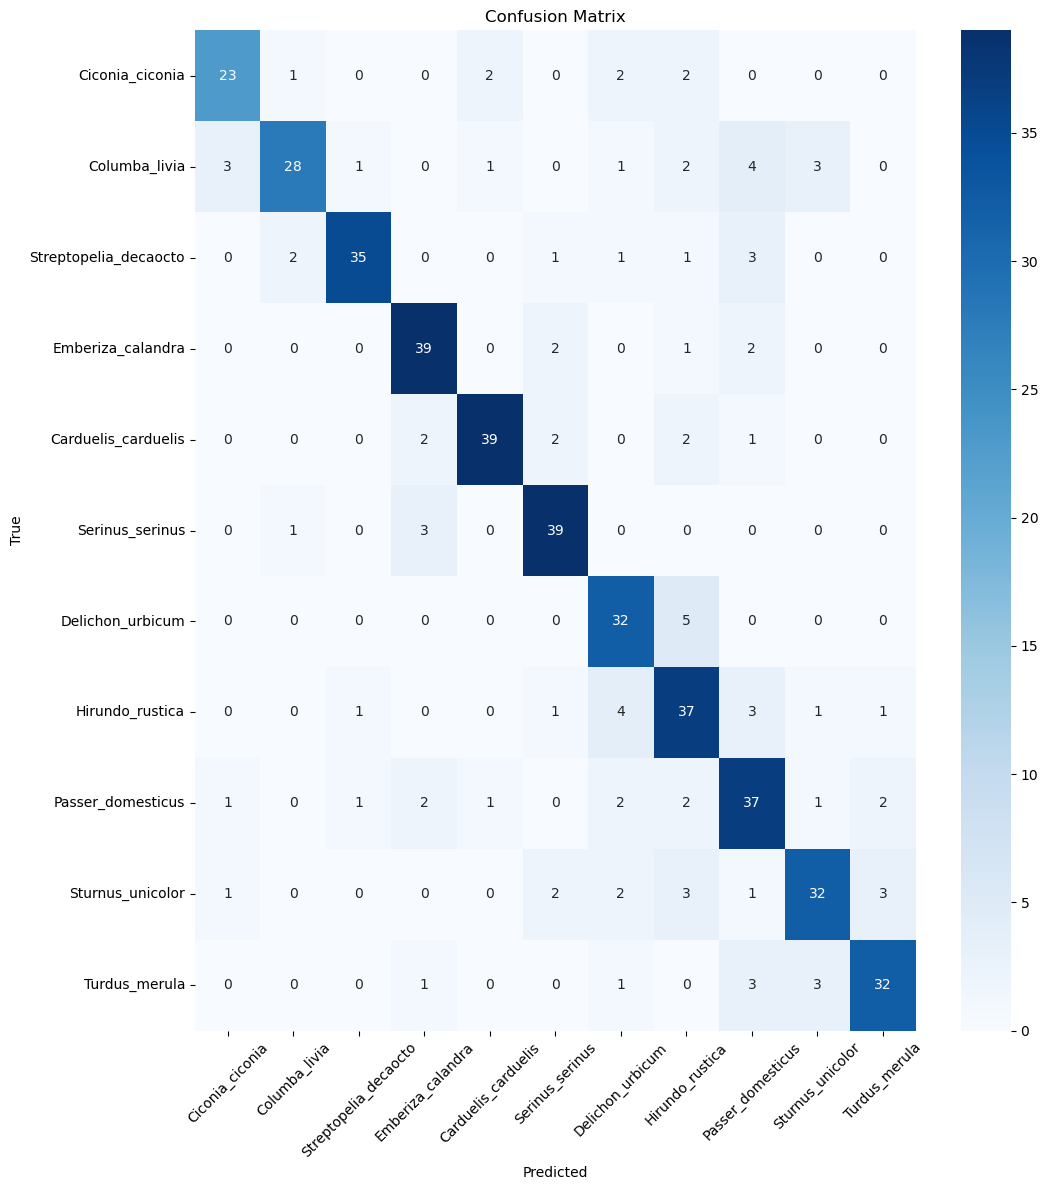


Test Set Metrics:
Loss: 0.8353
Accuracy: 0.7987
F1 Score: 0.7993

Final model saved!


In [ ]:
# 2. Train final model with best parameters
best_params = torch.load(os.path.join(MODEL_SAVE_DIR, 'bestparams.pth'))
best_model, best_history, best_metrics, best_camImages  = bestTrainModel(f"{MODEL_SAVE_DIR}/{OUTPUT_FILE}", best_params)
speciesModel = best_model.species if hasattr(best_model, 'species') else species


# 3. Generate confusion matrix
cm = best_metrics['confusion_matrix']
    
# 4. Plot results
plotting(
    history=best_history,
    cm=cm,
    metrics_dict=best_metrics,
    species=speciesModel,
    cam_images=best_camImages
)
    
# 5. Save final model
torch.save({
    'model_state_dict': best_model.state_dict(),
    'best_params': best_params,
    'metrics': best_metrics,
    'class_names': speciesModel
}, os.path.join(MODEL_SAVE_DIR, 'final_model.pth'))